<a href="https://colab.research.google.com/github/Nouman-wisal/pytorch/blob/main/02_pytorch_Neural_Network_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Network Classification model
classification is predicting whether something is one thing or another(there can be multiple things as options)

#1. Make classification data and get it ready

In [73]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.datasets import make_circles

X ,y =make_circles(n_samples=1000, noise=0.03, random_state=42)
print(X[:5])
print(y[:5],"\n")

len(X),X.shape , len(y),y.shape


[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0] 



(1000, (1000, 2), 1000, (1000,))

In [74]:


# convert it to data frame
df=pd.DataFrame({
    'X1': X[:,0],
    'X2': X[:,1],
    'label':y
})

print(df.head(5))
df["label"].value_counts() # meaning out 1000 features 500 has label=0 and 500 has label=1,they both have different colors

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0


,count
label,
1,500
0,500


#Visualizing the data through plotting
##Plotting the make circle toy data

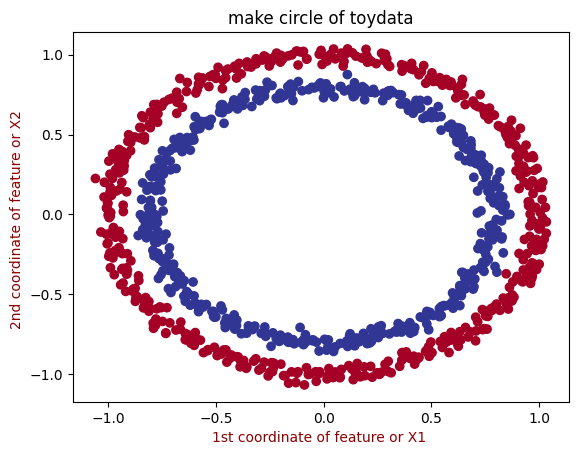

In [75]:


plt.scatter(X[:,0], X[:,1], c=y , cmap=plt.cm.RdYlBu)
plt.xlabel("1st coordinate of feature or X1 ",c="#8B0000")
plt.ylabel("2nd coordinate of feature or X2 ",c="#8B0000")
plt.title("make circle of toydata")

plt.show()


#Toy data comes in numpy format
###converting it to tensors before splitting for trainig and testing

In [76]:

print(type(X), X.dtype, type(y), y.dtype,"\n")

# converting X, y to tensors and changing dtype
X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.float)

print(type(X), X.dtype, type(y), y.dtype)

<class 'numpy.ndarray'> float64 <class 'numpy.ndarray'> int64 

<class 'torch.Tensor'> torch.float32 <class 'torch.Tensor'> torch.float32


#Splitting data for Trainig and Testing

In [77]:
from sklearn.model_selection import train_test_split

x_train , x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(x_train), len(x_test), len(y_train), len(y_test), x_train.shape

(800, 200, 800, 200, torch.Size([800, 2]))

#Building a Model for binary classification


1.   setup device agnostic code
1.   build model subclass from nn.Module
2.   setup loss and optimizer
2.   train and test model



In [78]:
device= 'cuda' if torch.cuda.is_available else 'cpu'
device , torch.__version__

('cuda', '2.6.0+cu124')

In [79]:
"""A simple neural network model for binary classification of circular data."""
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    """Initializes the model with two linear layers."""
    self.layer1 = nn.Linear(in_features=2, out_features=5)  # 1 hidden layer with 5 neurons
    self.layer2 = nn.Linear(in_features=5, out_features=1)  # the Output layer for binary classification


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """
    Performs a forward pass through the model.

    Args:
        x: The input tensor.

    Returns:
        The output tensor after passing through the linear layers.
    """
    return self.layer2(self.layer1(x))


In [80]:
model_0= CircleModelV0().to(device)
model_0
# model_0.state_dict()


CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

#The othe way to create this model.
this is for only simple models like ours

In [81]:
model_0= nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0
# model_0.state_dict()

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

#Setting up Loss_fn & Optimizer & Accuracy Calculator

In [82]:
# Setting up the loss function & Optimizer & Accuracy Calculator
# lossfn = BCELoss() requires the input to have already gone through activation function prior to input to BECLoss()

loss_fn = nn.BCEWithLogitsLoss() # comes with BUilt_in sigmoid activation function and better more stable numerically --> recommened

optimizer= torch.optim.Adam(params=model_0.parameters(),
                            lr= 0.1)

def accuracy_fn(y_true, y_pred):
  correct= torch.eq(y_true, y_pred).sum().item()
  acc= (correct / len(y_pred)) *100
  return acc

###Fyi test: our model outputs ***raw logits*** as preds, we have to turn them to ***prediction probabilities*** and then to ***prediction labels***

*   from **Raw Logits**  --->  **prediction probabilities`through sigmoid activation func`**  --->  **prediction labels(y_preds)`by rounding`**




In [83]:
# this is just fyi to be ussed after trainig

model_0.eval()

with torch.inference_mode():
  y_logits= model_0(x_test.to(device))

y_predss= torch.round(torch.sigmoid(y_logits))
# y_predss.squeeze()

print(y_predss[:5],"\n")
                              #OR

  # In full 1 step (logits -> pred probs -> pred labels)
with torch.inference_mode():
  y_predss_1= torch.round(torch.sigmoid(model_0(x_test.to(device))))

print(y_predss_1[:5],"\n")

# comparing &check which of them are equal to each other
print(torch.eq(y_predss, y_predss_1)[:5].squeeze())


tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0') 

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0') 

tensor([True, True, True, True, True], device='cuda:0')


#Trainig and Testing the Model

In [84]:
# converting data to device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch=1000

for epoch in range(epoch):
  model_0.train()

# the forward pass
  train_logits= model_0(x_train).squeeze()                    # the ypred after forward loss but it's in raw logits and must be converted to y_pred

  train_preds= torch.round(torch.sigmoid(train_logits))         # the y_preds

  # claculate the loss / accuracy
  train_loss= loss_fn(train_preds, y_train)

  train_accuracy= accuracy_fn(y_true=y_train, y_pred=train_preds)

  # zero grad
  optimizer.zero_grad()

  # back propagation
  train_loss.backward()

  # gradient descent
  optimizer.step()

                        # Now Testing the Model

  model_0.eval()

  with torch.inference_mode():
    # the forward pass
    test_logits= model_0(x_test).squeeze()

    test_preds= torch.round(torch.sigmoid(test_logits))

  # calculate the loss / accuracy
  test_loss= loss_fn(test_preds, y_test)

  test_accuracy= accuracy_fn(y_true=y_test, y_pred= test_preds)

  if epoch % 10 ==0:
    print(f'epoch:{epoch}, training loss: {train_loss:.5f}, training accuracy: {train_accuracy:.2f}, test loss: {test_loss:.5f}, testing accuracy: {test_accuracy:.2f}')


epoch:0, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:10, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:20, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:30, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:40, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:50, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:60, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:70, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:80, training loss: 0.77251, training accuracy: 51.88, test loss: 0.74393, testing accuracy: 57.50
epoch:90, training loss: 0.77251, training accuracy: 51.88, test 

# Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called plot_decision_boundary() - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [85]:
import requests
from pathlib import Path

if Path('helper_function.py').is_file():
  print('helper function file already exists,skipping download')

else:
  print('downloading content into helper functoin file')
  request= requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')

  # folder=Path('HelperFunctions').mkdir(parents=True, exist_ok=True)

  with open('helper_function.py','wb') as f:
    f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary


helper function file already exists,skipping download


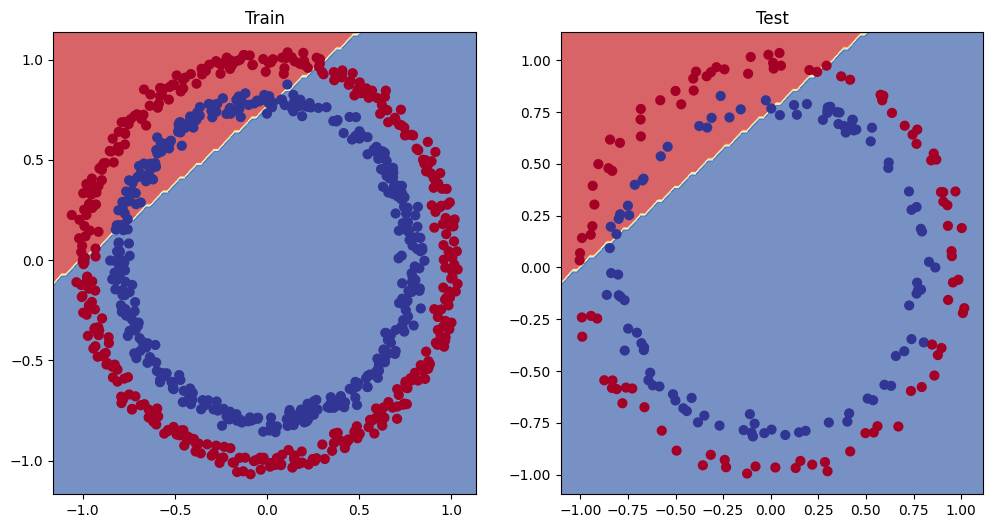

In [86]:


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, x_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, x_test, y_test)

